In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np
%matplotlib inline

## Готовим данные
Три файла с данными
1. исторические данные - train
2. Тестовые данные текущего момента - derived
3. Пример сабмита резкльтатов конкурса на кагле

In [2]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [3]:
data = pd.read_csv('data/train.csv')
data

,date,hits
0,2016-01-01,201979088
1,2016-01-02,223095158
2,2016-01-03,233791442
3,2016-01-04,259684220
4,2016-01-05,267112490
...,...,...
1091,2018-12-27,241134980
1092,2018-12-28,234865040
1093,2018-12-29,195884690
1094,2018-12-30,125587958


In [4]:
data_train = read_set('data/train.csv')
data_test =  read_set('data/derived.csv')
data_sample = read_set('data/sample_submission.csv')

In [5]:
data_train

,value
date,
2016-01-01,201979088
2016-01-02,223095158
2016-01-03,233791442
2016-01-04,259684220
2016-01-05,267112490
...,...
2018-12-27,241134980
2018-12-28,234865040
2018-12-29,195884690


### Проверим наши данные, что мы загрузили

In [6]:
print( data_train.info() )
print( data_test.info() )
print( data_sample.info() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


In [7]:
data_train.describe()

,value
count,1.096000e+03
mean,2.792255e+08
std,7.677884e+07
min,1.103556e+08
25%,2.317301e+08
50%,2.791131e+08
75%,3.287730e+08
max,4.550733e+08


In [8]:
data_test.describe()

,value
count,3.650000e+02
mean,2.250691e+08
std,6.798229e+07
min,1.055197e+08
25%,1.467913e+08
50%,2.525773e+08
75%,2.724223e+08
max,3.410300e+08


In [9]:
data_sample.describe()

,value
count,365.0
mean,110355560.0
std,0.0
min,110355560.0
25%,110355560.0
50%,110355560.0
75%,110355560.0
max,110355560.0


## Графики наших временных последовательностей

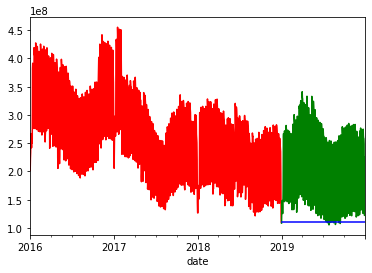

In [10]:
plt.figure()
data_train['value'].plot(kind = 'line', color='r')
data_test['value'].plot(kind = 'line', color='g')
data_sample['value'].plot(kind = 'line', color='b')
plt.show()

## Статистическая модель [ARIMA](https://ru.wikipedia.org/wiki/ARIMA)


In [11]:
# обучаем модель
arima_model=model = pm.auto_arima(data_train, seasonal = True,m = 4,test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=42026.193, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=42912.228, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=42352.663, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=42271.764, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=45821.113, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=42138.118, Time=0.35 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=42130.455, Time=0.84 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=41842.461, Time=1.47 sec
 ARIMA(2,0,2)(2,0,0)[4] intercept   : AIC=42088.126, Time=1.04 sec
 ARIMA(2,0,2)(2,0,2)[4] intercept   : AIC=41829.133, Time=2.29 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=42095.534, Time=1.86 sec
 ARIMA(1,0,2)(2,0,2)[4] intercept   : AIC=42117.810, Time=1.54 sec
 ARIMA(2,0,1)(2,0,2)[4] intercept   : AIC=42107.831, Time=1.27 sec
 ARIMA(3,0,2)(2,0,2)[4] intercept   : AIC=41841.310, Time=2.76 sec
 ARIMA(2,0,3)(2,0,2

In [12]:
prediction = pd.DataFrame(model.predict(n_periods = int(data_test.size)), data_test.index)

In [13]:
prediction

,0
date,
2019-01-01,1.822356e+08
2019-01-02,2.367393e+08
2019-01-03,2.596405e+08
2019-01-04,2.268471e+08
2019-01-05,1.368912e+08
...,...
2019-12-27,2.178902e+08
2019-12-28,2.313418e+08
2019-12-29,2.291895e+08


In [14]:
prediction = prediction .rename(columns = {0:'value'})

смотрим, что она нам предсказала

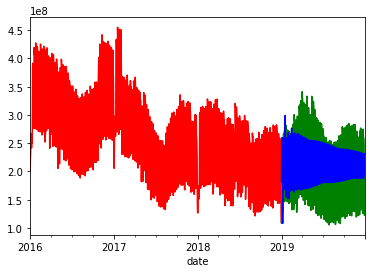

In [15]:
plt.figure()
data_train['value'].plot(kind = 'line', color='r')
data_test['value'].plot(kind = 'line', color='g')
#plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot(kind = 'line', color='b')
plt.show()

### Функция подсчета метрик для конкурса

In [16]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

### MAPE для ARIMA и тестового сабмишена

In [17]:
MAPE(data_test, prediction)

35.66518437628631

In [18]:
MAPE(data_test, data_sample)

44.81735178659308

## Из пандас строим датасет

In [19]:
class Stats:
    def __init__(self, dataset):
        self.mean = np.mean(dataset)
        self.std = np.std(dataset)
        self.data = (dataset - self.mean) / self.std

stats = Stats(data_train)

In [37]:
class TSDataset(Dataset):

    def __init__(self, data, seq_len):
        super().__init__()
        self._len = len(data) - seq_len + 1
        self.mean = stats.mean
        self.std = stats.std
        self.data = (data- self.mean) / self.std
        self.seq_len = seq_len

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len]
        targets = []
        days   = []
        months = []
        year = []
        for row in  d.iterrows():
            targets += [ row[1]['value'] ]
            days += [ row[0].day ]
            months += [row[0].month]
            year += [row[0].year]

        return torch.LongTensor(days), \
               torch.LongTensor(months), \
               torch.LongTensor(year), \
               torch.FloatTensor(targets)

In [38]:
ds_train = TSDataset(data_train, 20)
ds_test  = TSDataset(data_test, 20)
print(len(ds_train))


1077


## Теперь нужно определить нашу модель

In [149]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(333)

In [150]:
class TimeSeriesModel(nn.Module):
    def __init__(self, hidden_size: int, input_sizes: tuple):
        super().__init__()
        self.mon_emb = nn.Embedding(12+1, input_sizes[0])
        self.day_emb = nn.Embedding(31+1, input_sizes[1])

        # self._rnn = nn.LSTM(input_sizes[0] + input_sizes[1]+1,  hidden_size,  batch_first=True)
        self._rnn = nn.GRU(input_sizes[0] + input_sizes[1]+1,  hidden_size,  batch_first=True)
        self._output = nn.Linear(hidden_size, 1)

    def forward(self, batch, ctx = None):
        days, mons, years, targets = batch
        mon_tensor = self.mon_emb(mons)
        day_tensor = self.day_emb(days)
        rnn_input  = torch.cat([mon_tensor, day_tensor], dim=-1)
        targets = targets.unsqueeze(-1)
        rnn_input = torch.cat([rnn_input, targets ], dim=-1)
        rnn_input = rnn_input[:, :-1, :] if ctx is None else rnn_input
        output, ctx = self._rnn(rnn_input, ctx)
        output = self._output(output).squeeze()
        return output, ctx

### Определяем даталоадеры для теста и трейна

In [151]:
dl_train = DataLoader(ds_train, 8 , True)
dl_test = DataLoader(ds_test, 8 , False)

In [152]:
series_model = TimeSeriesModel(256, (16,32))

In [153]:
loss = nn.L1Loss()
optimizer = Adam(series_model.parameters(), lr=5e-4)

In [154]:
# инициализируем тензорборд, для вывода графиков
writer = SummaryWriter(log_dir='./rnn_hw')

### Обучаем модель

In [155]:
global_epoch = 0
global_iter = 0

In [156]:
def test_model(epoch):
    test_iter  = tqdm(dl_test)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:, 1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    return sum_loss

In [157]:
# модель обучаем в режиме teacher forcing, т.е. на вход подаем сразу всю последовательность,
# на выходе таргет должен быть смещен на один временной шаг, чтобы правильно считался лосс

for epoch in range(0, 15):
    epoch_iter = tqdm(dl_train)
    series_model.train()
    for batch in epoch_iter:
        optimizer.zero_grad()
        #print(batch)
        #break
        target = batch[-1][:,1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        batch_loss.backward()
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        optimizer.step()
        writer.add_scalar('Loss/train', batch_loss , global_iter)
        global_iter += 1
    with torch.no_grad():
        series_model.eval()
        test_model(global_epoch)
    global_epoch += 1

100%|██████████| 44/44 [00:00<00:00, 115.80it/s]



### TODO
Теперь нам нужно для нашего тестового сета сгенерировать результат, и сделать правильный сабмишен. В отличии от режима обучения мы не должгны использовать значения таргетов в тесте, поэтому нам придется тут реализовывать инкрементальный режим генерации сети, т.е. когда на вход подаются фичи и таргет с предыдущего шага на каждоим шаге генерации.

In [158]:
ds_evaluation = TSDataset(data_test, 1)
dl_evaluation = DataLoader(ds_evaluation, 1 , False)

In [159]:
for batch in DataLoader(ds_train, 1):
    input = batch

In [160]:
print(input)

[tensor([[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
         30, 31]]), tensor([[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12]]), tensor([[2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
         2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018]]), tensor([[-0.1291, -0.1936, -0.4293, -1.7672, -1.7341, -0.2415, -0.3038, -0.1620,
         -0.2428, -0.5024, -1.7640, -1.7625, -0.2683, -0.4030, -0.4092, -0.4963,
         -0.5780, -1.0860, -2.0020, -2.2004]])]


In [161]:
predicted_values = []
with open('data/my_submission.csv', 'wt') as sf:
    print('date,hits', file=sf)

    target, ctx = series_model(input)
    target = target[-1:]
    for i, batch in enumerate(dl_evaluation):
        batch[3] = target.unsqueeze(0)
        target, ctx = series_model(batch, ctx)
        target = torch.FloatTensor([target])
        print('%d-%02d-%02d,%d' %(batch[2], batch[1], batch[0], float(batch[3])*stats.std + stats.mean), file=sf)

In [162]:
data_nn_submission = read_set('data/my_submission.csv')
MAPE(data_test, data_nn_submission)

26.493310254661445

In [163]:
data_test

,value
date,
2019-01-01,108624560
2019-01-02,130814504
2019-01-03,147999398
2019-01-04,148669766
2019-01-05,131564540
...,...
2019-12-27,248681252
2019-12-28,139485986
2019-12-29,122282606


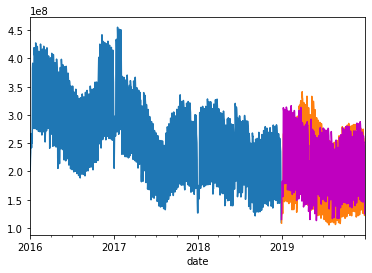

In [164]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
data_nn_submission['value'].plot(kind = 'line', color='m')
plt.show()

In [165]:
# seed: 111; model Lstm; hidden_size: 256: embedding (16; 32) - 28.5

In [129]:
# seed: 222; model Gru; hidden_size: 256: embedding (16; 32) - 27.7

In [130]:
# seed: 333; model Gru; hidden_size: 256: embedding (16; 32) - 26.4

In [131]:
# seed: 355; model Lstm; hidden_size: 256: embedding (16; 32) - 32.4